## Walmart Sales Forecasting
This project predicted daily sales for food categories at Walmart stores in California with the input data (06/19/2015-06/19/2016) covered item ids, item sales, item prices, departments, product categories, store ids and holiday/special events.
* Clean and merge data
* Investigate holiday impacts
* Explore Trends by State/Category/Stores
* Train Models

In [3]:
#import libraries
import warnings
import gc

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

### Clean and Merge Data
In this section, I cleaned three datasets (calendar, sales and prices) with reduced memory usage, combined them together and saved a copy of csv file with the most recent 366 days for future use.

In [2]:
#define a helper function to reduce memory sizes as the original datasets are large
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [ ]:
#read in data and reduce memory size
calendar = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/time-series-analysis/Walmart Sales/calendar.csv").pipe(reduce_mem_usage)
prices = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/time-series-analysis/Walmart Sales/sell_prices.csv").pipe(reduce_mem_usage)
sales = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/time-series-analysis/Walmart Sales/sales_train_evaluation.csv").pipe(reduce_mem_usage)

In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [ ]:
calendar.dtypes

In [ ]:
#select sales records in the most recent year
#1581 = 1947-366, where 1947 is the total number of columns
#first six columns are item and store info
sales_1yr = sales.iloc[:, np.r_[0:6, 1581:1947]]
#note: np.r_ stacks columns together
sales_1yr.to_csv('sales_1yr.csv', index = False)

In [ ]:
#1574 = 1940-366, where index 1940 corresponds to d_1941, the last day in sales dataset
calendar_1yr = calendar.iloc[1574:1941, :]
calendar_1yr.to_csv('calendar_1yr.csv', index = False)

In [ ]:
#change sales data from wide to long, preparing for merging with calendar data on "d"
id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
sales_1yr = sales_1yr.melt(id_vars=id_columns, var_name="d", value_name="demand")

In [ ]:
#merge with calendar and price datasets
sales_1yr = sales_1yr.merge(calendar_1yr[['wm_yr_wk', 'd', 'event_name_1', 'event_name_2']], how="left", on="d")
sales_1yr = sales_1yr.merge(prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

In [ ]:
sales_1yr.head(5)

In [ ]:
#define a helper function to extract digits from date variables
def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16)

In [ ]:
#only keep digit parts of time variables
sales_1yr["d"] = extract_num(sales_1yr["d"])
#reduce memory usage
sales_1yr = reduce_mem_usage(sales_1yr)

In [ ]:
sales_1yr.to_csv('input_1yr.csv', index = False)

### Investigate holiday impacts
In this section, I investigated the impact of holidays on daily sales of Hobbies_1 department at a California store (CA_1). Then, zoomed into the item daily sales of Hobbies_1_001 at the same location. My conclusion is daily sale at the department level doesn't change with holidays with a fixed pattern, sometimes local maxima, sometimes local minima; however, daily sale at the item level is even more intractable--sometimes there's no change in item daily sales at all during holidays.

In [5]:
#read in most recent (1 year) data
input_data = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/time-series-analysis/Walmart Sales/input_1yr.csv").pipe(reduce_mem_usage)

In [13]:
input_data[input_data.drop(['event_name_1', 'event_name_2', 'sell_price'], axis=1).isnull().any(axis = 1)]
#all missing values are about special events or from the price dataset

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wm_yr_wk,event_name_1,event_name_2,sell_price


In [14]:
# Check missing price distribution
input_data.loc[(input_data.demand>0) & (input_data.sell_price.isnull())]
# Missing prices are all related to zero demand -- not sold
# Since only sold items had prices recorded, it's not proper to use prices as a predictor of demands.

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wm_yr_wk,event_name_1,event_name_2,sell_price


In [ ]:
input_data.shape

In [ ]:
input_data.head(2)

In [15]:
#use a dummy variable to indicate if there's a holiday (event1 or event 2)
input_data['holiday'] = np.where(input_data.event_name_1.isnull() & input_data.event_name_2.isnull(), 0, 1)

In [17]:
#for store CA_1 and department Hobbies_1, summarize total demand (sales) per day for a year
sales_ca1_hb1 = input_data.loc[(input_data.dept_id == "HOBBIES_1") & (input_data.store_id == "CA_1")]\
                          .groupby(['d', 'holiday']).agg(daily_sales = ('demand', 'sum')).reset_index()

In [18]:
sales_ca1_hb1.head()

,d,holiday,daily_sales
0,1576,0,631
1,1577,0,622
2,1578,1,414
3,1579,0,420
4,1580,0,541


In [22]:
#extract day indices with a holiday
days_holiday = input_data.loc[input_data.holiday==1].d.unique()

In [23]:
days_holiday

array([1578, 1588, 1600, 1602, 1605, 1618, 1632, 1683, 1700, 1718, 1737,
       1748, 1763, 1781, 1792, 1799, 1805, 1816, 1836, 1839, 1843, 1844,
       1846, 1875, 1882, 1885, 1919, 1920, 1924, 1927], dtype=int16)

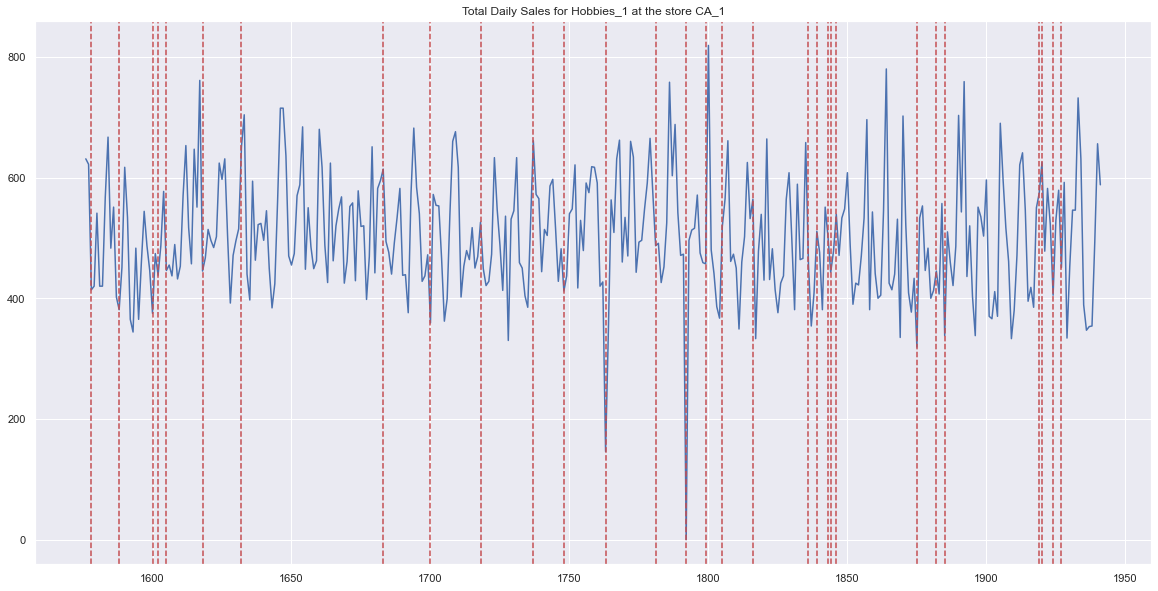

In [24]:
#plot daily sales of hobbies_1 at CA_1 store. red lines indicate a holiday
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sales_ca1_hb1['d'], sales_ca1_hb1['daily_sales'])
ax.set(title='Total Daily Sales for Hobbies_1 at the store CA_1')
for xc in days_holiday:
    ax.axvline(x=xc, color='r', linestyle='--')

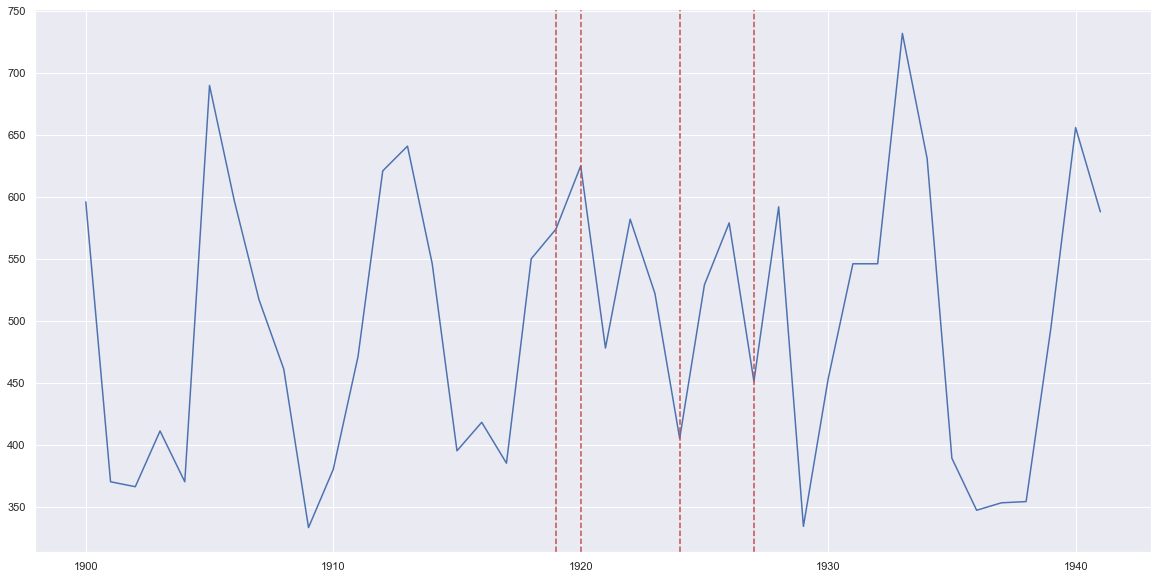

In [25]:
#zoom in the last part
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sales_ca1_hb1.loc[sales_ca1_hb1.d>=1900]['d'], sales_ca1_hb1.loc[sales_ca1_hb1.d>=1900]['daily_sales'])
for xc in days_holiday:
    if xc >= 1900:
        ax.axvline(x=xc, color='r', linestyle='--')

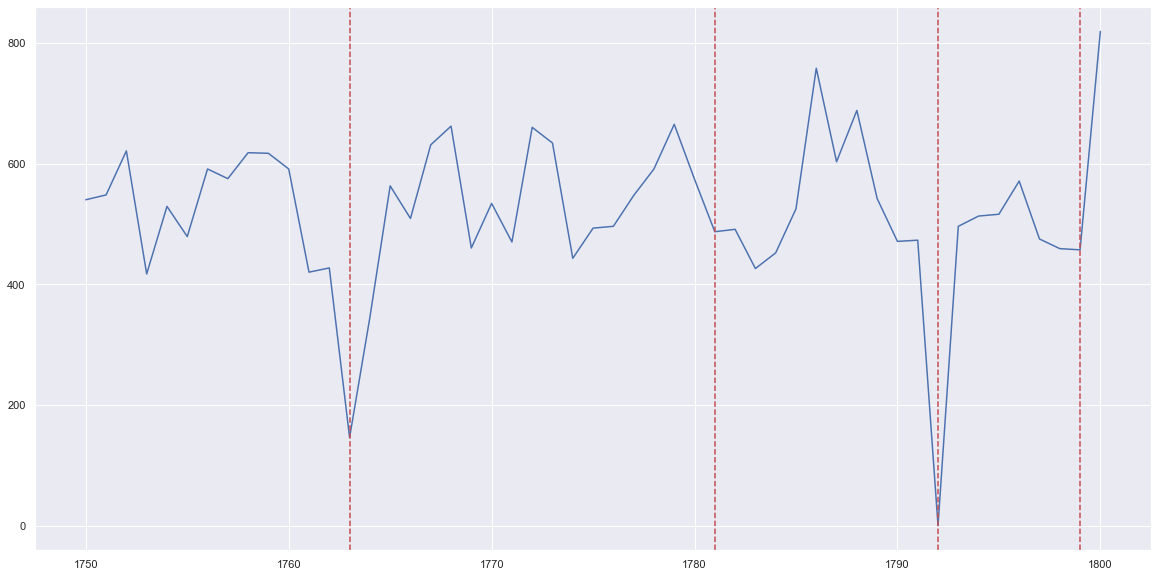

In [26]:
#zoom in the middle part
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sales_ca1_hb1.loc[(sales_ca1_hb1.d>=1750) & (sales_ca1_hb1.d <=1800)]['d'], sales_ca1_hb1.loc[(sales_ca1_hb1.d>=1750) & (sales_ca1_hb1.d <=1800)]['daily_sales'])
for xc in days_holiday:
    if xc >= 1750 and xc<= 1800:
        ax.axvline(x=xc, color='r', linestyle='--')

Two cases of total daily sales at a store when there's a holiday, according to the plot:
* Local maxima/minima on holidays
* Close to local maxima/minima when two holidays were very close

Conclusion: there's no need to view a few days before or after a holiday also as days with speical events

In [27]:
#for the item HOBBIES_1_001 at store CA_1 and department Hobbies_1, summarize total demand (sales) per day for a year
sales_ca1_hb1_001 = input_data.loc[(input_data.item_id=='HOBBIES_1_001') 
                                   & (input_data.dept_id == "HOBBIES_1") 
                                   & (input_data.store_id == "CA_1")]\
                              .groupby(['d', 'holiday']).agg(daily_sales = ('demand', 'sum'))\
                              .reset_index()

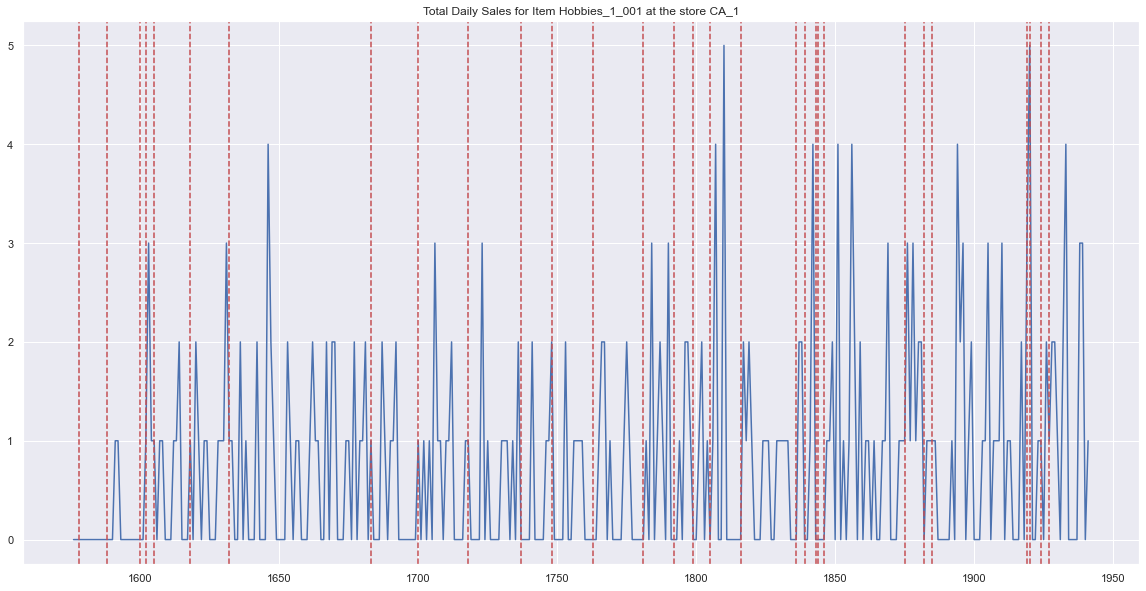

In [28]:
#plot daily sales of item hobbies_1_001 at CA_1 store. red lines indicate a holiday
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sales_ca1_hb1_001['d'], sales_ca1_hb1_001['daily_sales'])
ax.set(title='Total Daily Sales for Item Hobbies_1_001 at the store CA_1')
for xc in days_holiday:
    ax.axvline(x=xc, color='r', linestyle='--')

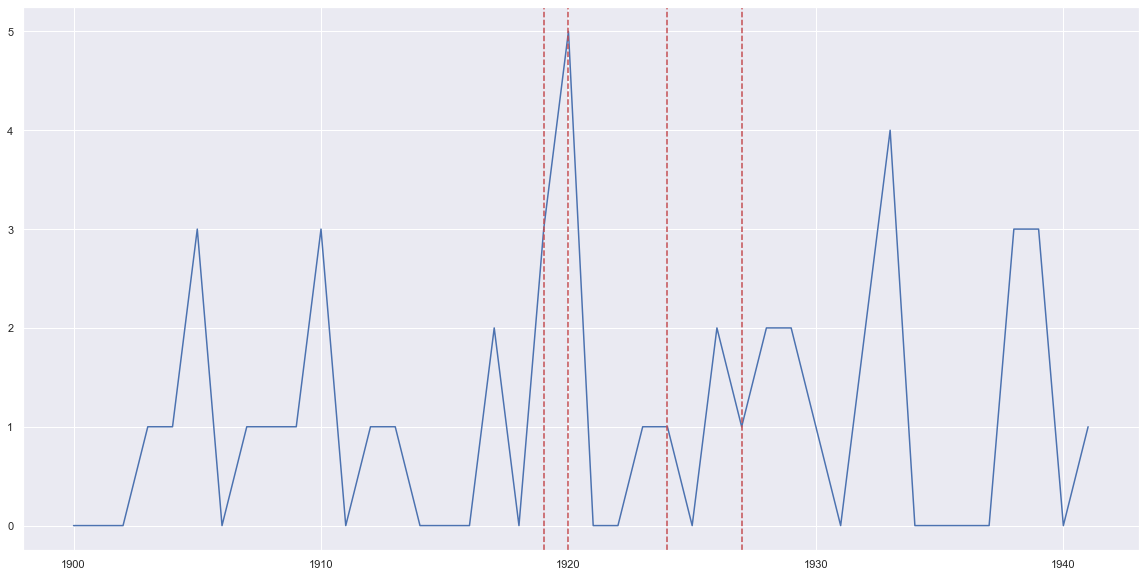

In [29]:
#zoom in the last part
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sales_ca1_hb1_001.loc[sales_ca1_hb1_001.d>=1900]['d'], sales_ca1_hb1_001.loc[sales_ca1_hb1_001.d>=1900]['daily_sales'])
for xc in days_holiday:
    if xc >= 1900:
        ax.axvline(x=xc, color='r', linestyle='--')

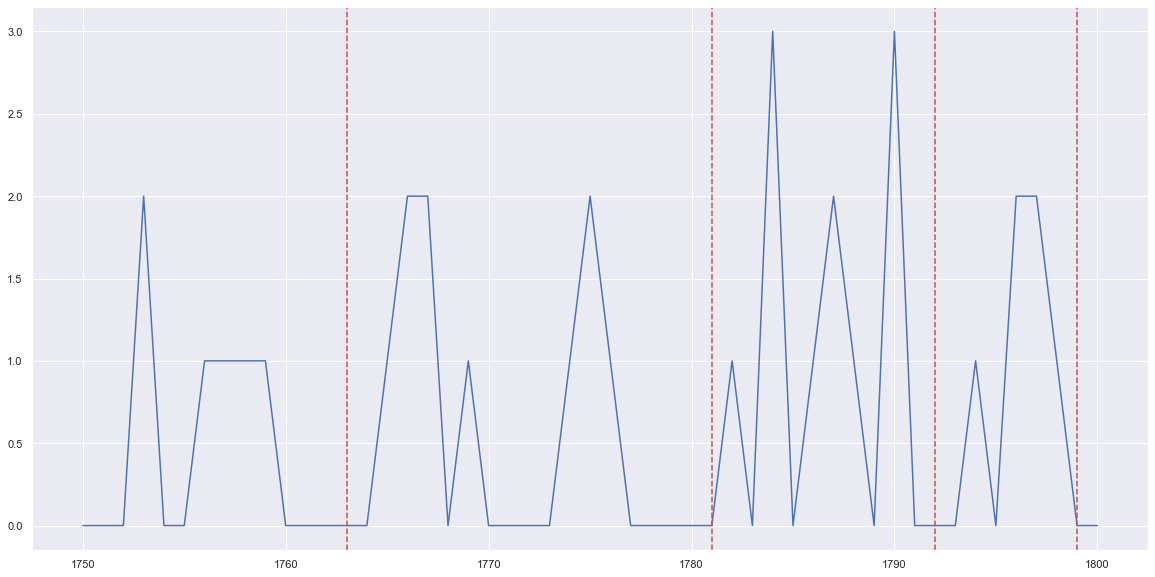

In [30]:
#zoom in the middle part
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(sales_ca1_hb1_001.loc[(sales_ca1_hb1_001.d>=1750) & (sales_ca1_hb1_001.d <=1800)]['d'], sales_ca1_hb1_001.loc[(sales_ca1_hb1.d>=1750) & (sales_ca1_hb1.d <=1800)]['daily_sales'])
for xc in days_holiday:
    if xc >= 1750 and xc<= 1800:
        ax.axvline(x=xc, color='r', linestyle='--')

Three cases of item daily sales at a store when there's a holiday, according to the plot:
* Local maxima/minima on holidays
* Close to local maxima/minima when two holidays were very close
* Increased from zero or decreased to zero. This happens to non-holiday days also
* Stayed zero

Conclusion: 
* There's no need to view a few days before or after a holiday also as days with speical events
* Holidays don't always make an impact on item sales

### Explore Trends by State/Category/Stores
In this section, I plotted the trend of daily total sales at state, category and store-level and chose a level to build models. The category-level was chosen, because each trend of three categories was clearly separable from one another and had obvious seasonality.
* Trend by State

In [31]:
input_data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wm_yr_wk,event_name_1,event_name_2,sell_price,holiday
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1576,0,11517,NaN,NaN,8.26,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1576,0,11517,NaN,NaN,3.97,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1576,1,11517,NaN,NaN,2.97,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1576,4,11517,NaN,NaN,4.64,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1576,0,11517,NaN,NaN,2.88,0


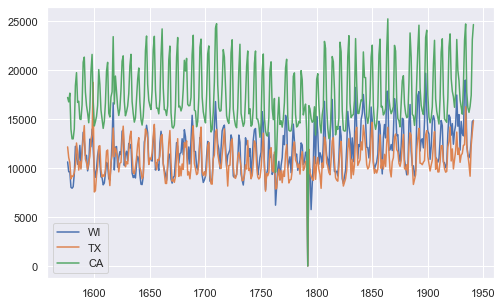

In [32]:
#check if the trend of sales is different across three states: WI, CA and TX
state = input_data.state_id.unique()
fig, ax = plt.subplots(figsize=(8,5))
for s in state:
    temp = input_data.loc[(input_data.state_id == s)]\
            .groupby('d')\
            .agg(daily_sales = ('demand', 'sum'))\
            .reset_index()
    ax.plot(temp['d'], temp['daily_sales'])
    ax.legend(state)

CA's trend is much higher than WI and TX. For WI and TX, WI's trend was slightly below TX's trend in the second half of 2015, then slightly it in the first half of 2016. These observations suggest a state-level model. 
* Trend by Category

Text(0, 0.5, 'Sales')

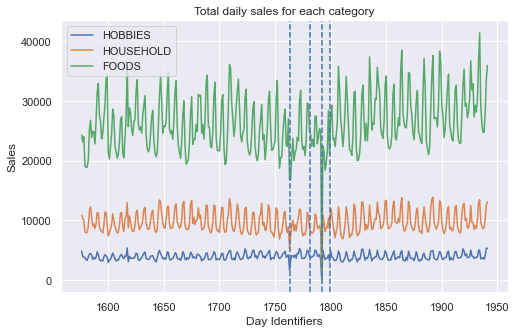

In [33]:
Cat = input_data['cat_id'].unique()
fig, ax = plt.subplots(figsize=(8,5))
for c in Cat:
    temp = input_data.loc[(input_data.cat_id == c)]\
            .groupby('d')\
            .agg(daily_sales = ('demand', 'sum'))\
            .reset_index()
    ax.plot(temp['d'], temp['daily_sales'])
    ax.legend(Cat)
for xc in days_holiday:
    if xc >= 1750 and xc<= 1800:
        ax.axvline(x=xc, color='b', linestyle='--')
ax.set(title = 'Total daily sales for each category')  
ax.set_xlabel('Day Identifiers')
ax.set_ylabel('Sales')

Text(0, 0.5, 'Sales')

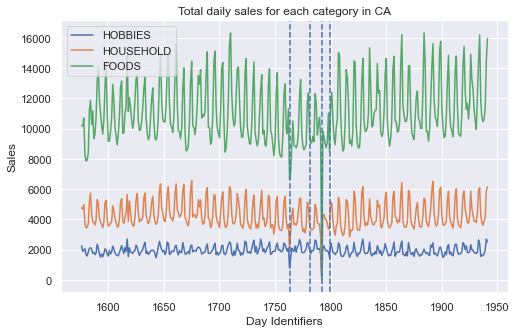

In [34]:
Cat = input_data['cat_id'].unique()
fig, ax = plt.subplots(figsize=(8,5))
for c in Cat:
    temp = input_data.loc[(input_data.cat_id == c) & (input_data.state_id=='CA')]\
            .groupby('d').agg(daily_sales = ('demand', 'sum')).reset_index()
    ax.plot(temp['d'], temp['daily_sales'])
    ax.legend(Cat)
for xc in days_holiday:
    if xc >= 1750 and xc<= 1800:
        ax.axvline(x=xc, color='b', linestyle='--')
ax.set(title = 'Total daily sales for each category in CA')  
ax.set_xlabel('Day Identifiers')
ax.set_ylabel('Sales')

In [35]:
del temp
gc.collect()

25983

In [36]:
# Check the irregular global minima of food sales
input_data.loc[input_data.d==1792]

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,wm_yr_wk,event_name_1,event_name_2,sell_price,holiday
6585840,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1792,0,11547,Christmas,NaN,8.26,1
6585841,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1792,0,11547,Christmas,NaN,3.97,1
6585842,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1792,0,11547,Christmas,NaN,2.97,1
6585843,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1792,0,11547,Christmas,NaN,4.64,1
6585844,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1792,0,11547,Christmas,NaN,2.88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6616325,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1792,0,11547,Christmas,NaN,2.50,1
6616326,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1792,0,11547,Christmas,NaN,2.00,1
6616327,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1792,0,11547,Christmas,NaN,3.98,1
6616328,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1792,0,11547,Christmas,NaN,1.28,1


Category-level daily total sales are pretty separable. Household and food categories were pretty stable and presented strong seasonality. The significant downfall of the sales of Food Category was due to the Christmas of 2015.
* Trend by Stores

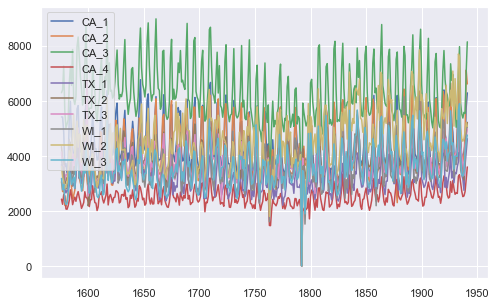

In [37]:
Stores = input_data['store_id'].unique()
fig, ax = plt.subplots(figsize=(8,5))
for st in Stores:
    temp = input_data.loc[(input_data.store_id == st)]\
            .groupby('d')\
            .agg(daily_sales = ('demand', 'sum'))\
            .reset_index()
    ax.plot(temp['d'], temp['daily_sales'])
    ax.legend(Stores)

The overall trend at store-level is very similar to the trend at category-level, with lots of overlaps among stores. I decided to build cateogry-level models.

### Train Models
In this section, I trained ARIMA, Decision Tree, Random Forest and Light GBM. Then, compared results.
* ARIMA

In [61]:
#Augmented Dickey-Fuller Test to check integration order
#Ho: not stationary
#H1: stationary
input_ca = input_data.loc[input_data.state_id == 'CA']
input_ca.to_csv('input_ca.csv', index = False)

In [39]:
del input_data
gc.collect()

742

In [4]:
input_ca = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/time-series-analysis/Walmart Sales/input_ca.csv")

In [5]:
input_ca_cat = input_ca.groupby(['cat_id','d']).agg(daily_sales = ('demand', 'sum')).reset_index()

In [6]:
test_res = {}
Cat = input_ca_cat['cat_id'].unique()
for c in Cat:
    # This time-series is much more complicated than a AR(1) series => use Augmented Dickey Fuller Test
    test_res[c]=adfuller(input_ca_cat.loc[input_ca_cat.cat_id==c]['daily_sales'])
test_res

{'FOODS': (-2.581480837668372,
  0.09688552631219105,
  14,
  351,
  {'1%': -3.44911857009962,
   '5%': -2.8698097654570507,
   '10%': -2.5711757061225153},
  5884.603369242338),
 'HOBBIES': (-3.4326177018702304,
  0.009895937408940472,
  13,
  352,
  {'1%': -3.4490648539347544,
   '5%': -2.8697861692116478,
   '10%': -2.5711631253228306},
  4793.473520162877),
 'HOUSEHOLD': (-1.9991674911663337,
  0.2869382445422097,
  15,
  350,
  {'1%': -3.4491725955218655,
   '5%': -2.8698334971428574,
   '10%': -2.5711883591836733},
  5245.101338942865)}

Only p-value of Hobbies (0.0099) is less than 0.05. I rejected the null hypothesis of daily sales being non-stationary for Hobbies category. Foods and household categories, however, need to be differenced.

In [7]:
input_ca_foods = input_ca_cat.loc[input_ca_cat.cat_id=='FOODS']
input_ca_hs = input_ca_cat.loc[input_ca_cat.cat_id=='HOUSEHOLD']
input_ca_hobbies = input_ca_cat.loc[input_ca_cat.cat_id=='HOBBIES']

In [8]:
input_ca_foods['first_diff'] = input_ca_foods['daily_sales'] - input_ca_foods['daily_sales'].shift(1)
input_ca_hs['first_diff'] = input_ca_hs['daily_sales'] - input_ca_hs['daily_sales'].shift(1)

In [9]:
input_ca_foods.head(5)

,cat_id,d,daily_sales,first_diff
0,FOODS,1576,10182,NaN
1,FOODS,1577,10184,2.0
2,FOODS,1578,10710,526.0
3,FOODS,1579,8215,-2495.0
4,FOODS,1580,7864,-351.0


In [10]:
adfuller(input_ca_foods['first_diff'].dropna())

(-7.4928273110853025,
 4.458805020075203e-11,
 13,
 351,
 {'1%': -3.44911857009962,
  '5%': -2.8698097654570507,
  '10%': -2.5711757061225153},
 5872.775908746674)

In [11]:
adfuller(input_ca_hs['first_diff'].dropna())

(-7.4577597293483455,
 5.455025041587284e-11,
 14,
 350,
 {'1%': -3.4491725955218655,
  '5%': -2.8698334971428574,
  '10%': -2.5711883591836733},
 5233.300853765576)

In [12]:
#p-value is smaller, but still not siginificant. Need to differentiate again (2nd diff)
input_ca_foods['second_diff'] = input_ca_foods['first_diff'] - input_ca_foods['first_diff'].shift(1)
input_ca_hs['second_diff'] = input_ca_hs['first_diff'] - input_ca_hs['first_diff'].shift(1)
input_ca_foods.head(5)

,cat_id,d,daily_sales,first_diff,second_diff
0,FOODS,1576,10182,NaN,NaN
1,FOODS,1577,10184,2.0,NaN
2,FOODS,1578,10710,526.0,524.0
3,FOODS,1579,8215,-2495.0,-3021.0
4,FOODS,1580,7864,-351.0,2144.0


In [13]:
adfuller(input_ca_foods['second_diff'].dropna())

(-9.684320684841467,
 1.181669110391987e-16,
 16,
 347,
 {'1%': -3.449336554273722,
  '5%': -2.8699055166063085,
  '10%': -2.571226758215748},
 5898.38873008727)

In [14]:
adfuller(input_ca_hs['second_diff'].dropna())

(-10.486685066825105,
 1.1754251284033695e-18,
 16,
 347,
 {'1%': -3.449336554273722,
  '5%': -2.8699055166063085,
  '10%': -2.571226758215748},
 5263.075007383312)

In [15]:
input_ca_foods['third_diff'] = input_ca_foods['second_diff'] - input_ca_foods['second_diff'].shift(1)
input_ca_hs['third_diff'] = input_ca_hs['second_diff'] - input_ca_hs['second_diff'].shift(1)
adfuller(input_ca_foods['third_diff'].dropna())
adfuller(input_ca_hs['third_diff'].dropna())

(-13.006496351161248,
 2.6211366077118204e-24,
 17,
 345,
 {'1%': -3.4494474563375737,
  '5%': -2.8699542285903887,
  '10%': -2.5712527305187987},
 5316.258968096278)

As integrated orders go up, p-values within Dickey-Fuller tests jump up and down for Foods and Household categories. I'll stop here for FOODS and HOUSEHOLDS instead of running into a rabbit hole. Below is the training of ARIMA for HOBBIES category.

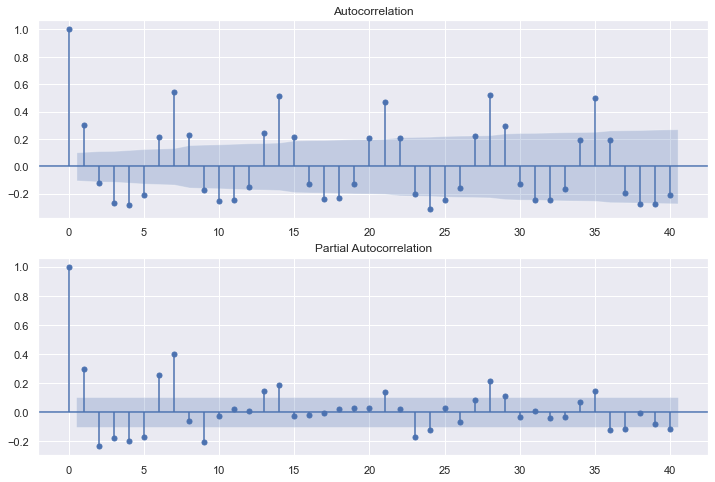

In [16]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(input_ca_hobbies['daily_sales'], lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(input_ca_hobbies['daily_sales'], lags = 40, ax= ax2)

In [27]:
#train ARIMA model accordingly
ARMA_model = ARIMA(input_ca_hobbies['daily_sales'], order = (4, 0 , 1))
model_fit = ARMA_model.fit()
model_fit.aic

5155.3154176052285

<AxesSubplot:>

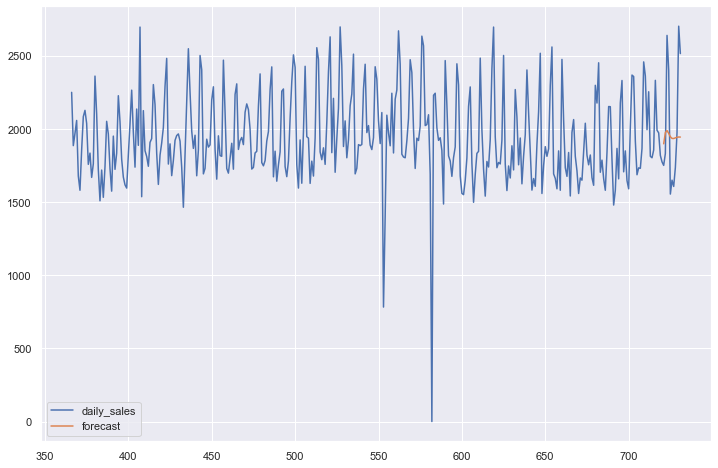

In [19]:
input_ca_hobbies['forecast'] = model_fit.predict(start=355, end = 365, dynamic = True)
input_ca_hobbies[['daily_sales', 'forecast']].plot(figsize = (12, 8))

In [20]:
#the prediction is not as good as desire
#use SARIMA to incoporate seasonality
sarima_model = sm.tsa.statespace.SARIMAX(input_ca_hobbies['daily_sales'], order = (2, 0, 1), seasonal_order = (2, 0, 1, 3))
sarima_results = sarima_model.fit()

<AxesSubplot:>

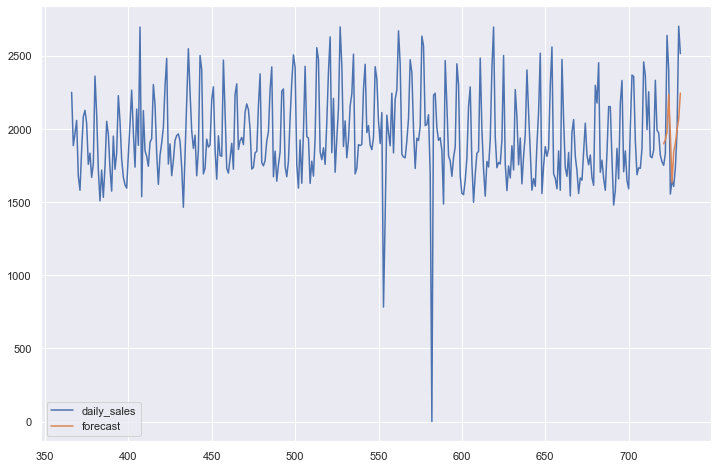

In [21]:
# Dynamic = False means the lagged dependent variables are used, rather than forecasted values
input_ca_hobbies['forecast'] = model_fit.predict(start=355, end = 365, dynamic = False)
input_ca_hobbies[['daily_sales', 'forecast']].plot(figsize = (12, 8))

The results from ARIMA and SARIMA are both not as desired, probably because these models are too simple and don't use extra information, such as holidays.
* Decision Tree, Random Forest and Gradient Boosting Tree

In [20]:
input_ca_foods.head()

,cat_id,d,daily_sales,first_diff,second_diff,third_diff
0,FOODS,1576,10182,NaN,NaN,NaN
1,FOODS,1577,10184,2.0,NaN,NaN
2,FOODS,1578,10710,526.0,524.0,NaN
3,FOODS,1579,8215,-2495.0,-3021.0,-3545.0
4,FOODS,1580,7864,-351.0,2144.0,5165.0


In [21]:
# The previous input_ca_foods dataset doesn't have event information.
# Create a dummy variable to indicate if there's a holiday (event1 or event 2)
input_ca['holiday'] = np.where(input_ca.event_name_1.isnull() & input_ca.event_name_2.isnull(), 0, 1)
input_ca_cat = input_ca.groupby(['cat_id','holiday','d']).agg(daily_sales = ('demand', 'sum')).reset_index()

In [22]:
input_ca_cat['lag1'] = input_ca_cat['daily_sales'].shift(1)
input_ca_cat['lag2'] = input_ca_cat['daily_sales'].shift(2)

In [23]:
# Drop the two earliest days as their lags were NAs.
input_ca_cat.dropna(inplace=True)
train = input_ca_cat.loc[input_ca_cat.cat_id == 'FOODS'][['cat_id', 'holiday', 'd', 'lag1', 'lag2']]
y_train = input_ca_cat.loc[input_ca_cat.cat_id == 'FOODS']['daily_sales']

In [24]:
input_ca_cat.head()

,cat_id,holiday,d,daily_sales,lag1,lag2
2,FOODS,0,1579,8215,10184.0,10182.0
3,FOODS,0,1580,7864,8215.0,10184.0
4,FOODS,0,1581,7919,7864.0,8215.0
5,FOODS,0,1582,8405,7919.0,7864.0
6,FOODS,0,1583,11209,8405.0,7919.0


In [25]:
train.shape, y_train.shape

((364, 5), (364,))

In [28]:
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true))

In [29]:
cost_scorer = make_scorer(median_absolute_percentage_error, greater_is_better=False)

In [30]:
dt = DecisionTreeRegressor(max_depth=40, min_samples_split=10, random_state=1)
param_grid_dt={
            'max_depth': range(2,50)
        }
search_dt = GridSearchCV(estimator = dt, param_grid=param_grid_dt, cv=10, scoring=cost_scorer, n_jobs=-1)   
search_dt.fit(train, y_train)
print(f"{search_dt.best_params_}")
print(f"{-search_dt.best_score_:.4}")

{'max_depth': 4}
0.07646


In [31]:
#random forest
rdf = RandomForestRegressor(max_depth=4, n_estimators=50, random_state=1)
param_grid_rdf={
                'max_depth': range(2,50),
                'n_estimators': (50, 100)
                }
search_rdf = GridSearchCV(estimator = rdf, param_grid= param_grid_rdf, cv=10, scoring=cost_scorer, n_jobs=-1)   
search_rdf.fit(train, y_train)
print(f"{search_rdf.best_params_}")
print(f"{-search_rdf.best_score_:.4}")

{'max_depth': 7, 'n_estimators': 100}
0.06714


In [32]:
#Lightgbm
_lgb = lgb.LGBMRegressor(boosting_type='gbdt', 
                         objective='regression', num_leaves=10,
                         learning_rate=0.12, 
                         n_estimators=50, 
                         max_depth=4,
                         random_state=1)
param_grid_lgb={'num_leaves': [10, 20],
                'learning_rate': np.linspace(0.01, 0.2, 20),
                'max_depth': range(2,50),
                'n_estimators': (50, 100)
                }
search_lgb = GridSearchCV(estimator = _lgb, param_grid = param_grid_lgb, cv=10, scoring=cost_scorer, n_jobs=-1)   
search_lgb.fit(train, y_train)
print(f"{search_lgb.best_params_}")
print(f"{-search_lgb.best_score_:.4}")

{'learning_rate': 0.09999999999999999, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 20}
0.06529
